In [ ]:
import numpy as np
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt


In [ ]:
!pip install wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 133 kB 41.2 MB/s 
     |████████████████████████████████| 170 kB 29.9 MB/s 
     |████████████████████████████████| 97 kB 5.9 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=f38ea3066a83ba109867edd9964f12550464f1521508deedae711865ec830501
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=11b4100c93285b72f6946ad3e75389c5913034f47deb123e041770c4ab18aac8
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# transform = transforms.Compose([transforms.ToTensor(),
#                                 # transforms.Normalize((0.5,),(0.5,)),
#                                 transforms.Resize((64,64))])
# train_dataset = CIFAR10(root='data', train=True, transform=transform, download=True)

In [ ]:
images = np.load('drive/MyDrive/images.npy') # путь до картинок из иглу
images = np.transpose(images,(0,3,1,2))
images = torch.Tensor(images)
train_dataset = images

In [ ]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [100000, 13873])
# test_set = CIFAR10(root='data', train=False, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
# test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


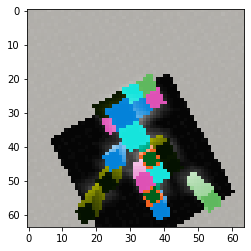

In [ ]:
for data in train_loader:
  print(data.shape)
  # plt.imshow((data[0]/255).reshape(64,64,3))
  image = data[0]
  # image = np.transpose(image,0)
  print(image.shape)
  # data = data.reshape(256,1,64,64,3)
  print(data[0].shape)
  tensor_to_pil = transforms.ToPILImage()(image)
  plt.imshow(tensor_to_pil)
  break

In [ ]:
class VisualEncoder(nn.Module):
    def __init__(self, features_dim=512):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=0),  # (3, 64, 64) -> (32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0), #             -> (64, 5, 5)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0), #             -> (64, 3, 3)
            nn.ReLU(),
            nn.Flatten(),
        )

        n_flatten = 1024
        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, x):
        return self.linear(self.cnn(x))

class VisualDecoder(nn.Module):
    def __init__(self, features_dim=512):
        super().__init__()

        n_flatten = 1024
        self.linear = nn.Sequential(nn.Linear(features_dim, n_flatten), nn.ReLU())

        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3,stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0,output_padding=1),
            # nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=8,stride=4, padding=0),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], 64, 4, 4)
        x = self.cnn(x)
        return x 

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self,
               encoder_class : object = VisualEncoder,
               decoder_class : object = VisualDecoder):
    super().__init__()
    self.encoder = encoder_class()
    self.decoder = decoder_class()
  def forward(self, x):
    encode = self.encoder(x)
    decode = self.decoder(encode)
    return decode
model = Autoencoder()
model.to('cuda')

Autoencoder(
  (encoder): VisualEncoder(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (decoder): VisualDecoder(
    (linear): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
    )
    (cnn): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(32, 3, kernel_size=(8, 8), stride=(4, 4))
      (5): Tanh()
    )
  )
)

torch.Size([1, 3, 64, 64])

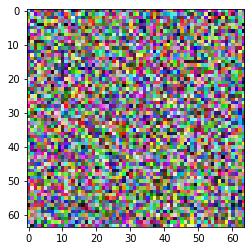

In [ ]:
test = torch.randn(1,3, 64,64)
resized = torch.reshape(test,[1,3,64,64])
tensor_to_pil = transforms.ToPILImage()(resized.squeeze_(0))
plt.imshow(tensor_to_pil)
model(test.to('cuda')).shape

In [ ]:
# config_defaults = {
#     'epochs': 10,
#     'batch_size': 256,
#     'learning_rate': 1e-3,
#     'optimizer': 'adam',
#     'model': 'VisualEncoder'
#     }
# wandb.init(project='test_try', entity='neuro_ai',config=config_defaults)
# config = wandb.config
# config = config_defaults
optimizer = optim.Adam(model.parameters(), config.learning_rate)
criterion = torch.nn.MSELoss()
for epoch in range(50):
  #train
  model.train()
  # train_loss = []
  for data in train_loader:
    data/=255
    data = data.to('cuda')
    predict = model(data)
    loss = criterion(predict, data)
    # train_loss.append(loss.item())
    wandb.log({"train_loss":loss})
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # train_loss = np.array(train_loss).mean()
  #evaluate
  model.eval()
  val_loss = []
  for data in val_loader:
      data/=255
      data = data.to('cuda')
      predict = model(data)
      loss = criterion(predict, data)
      val_loss.append(loss.item())
  val_loss = np.array(val_loss).mean()
  wandb.log({'val_loss': val_loss})
  print(loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward

In [ ]:
torch.save(model.encoder,'encoder_model.pth')

In [ ]:
torch.save(model.state_dict(), 'autoencoder_weights.pth')
torch.save(model,'autoencoder_model.pth')
torch.save(model.encoder.state_dict(),'encoder_weigths.pth')

In [ ]:
torch.load('encoder_model.pth')

VisualEncoder(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
  )
)

In [ ]:
for data, label in test_loader:
  print(data.shape)
  data = data.to('cuda')
  tensor_to_pil = transforms.ToPILImage()(data[24,:,:,:].squeeze_(0))
  predict = model(data)
  predict_to_pil = transforms.ToPILImage()(predict[24,:,:,:].squeeze_(0))
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 64, 64])


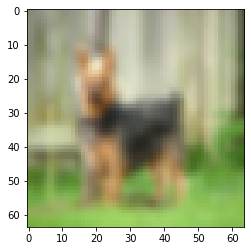

In [ ]:
plt.imshow(tensor_to_pil)

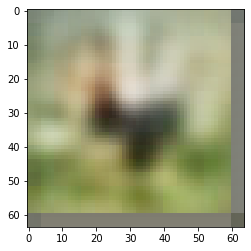

In [ ]:
plt.imshow(predict_to_pil)